In [5]:
import numpy as np
import cv2
from scipy.spatial.distance import squareform, pdist, cdist
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

In [6]:
def plot_matches(ax, image1, image2, keypoints1, keypoints2, matches,
                 keypoints_color='k', matches_color=None, only_matches=False):
    """Plot matched features.
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Matches and image are drawn in this ax.
    image1 : (N, M [, 3]) array
        First grayscale or color image.
    image2 : (N, M [, 3]) array
        Second grayscale or color image.
    keypoints1 : (K1, 2) array
        First keypoint coordinates as ``(row, col)``.
    keypoints2 : (K2, 2) array
        Second keypoint coordinates as ``(row, col)``.
    matches : (Q, 2) array
        Indices of corresponding matches in first and second set of
        descriptors, where ``matches[:, 0]`` denote the indices in the first
        and ``matches[:, 1]`` the indices in the second set of descriptors.
    keypoints_color : matplotlib color, optional
        Color for keypoint locations.
    matches_color : matplotlib color, optional
        Color for lines which connect keypoint matches. By default the
        color is chosen randomly.
    only_matches : bool, optional
        Whether to only plot matches and not plot the keypoint locations.
    """

    image1.astype(np.float32)
    image2.astype(np.float32)

    new_shape1 = list(image1.shape)
    new_shape2 = list(image2.shape)

    if image1.shape[0] < image2.shape[0]:
        new_shape1[0] = image2.shape[0]
    elif image1.shape[0] > image2.shape[0]:
        new_shape2[0] = image1.shape[0]

    if image1.shape[1] < image2.shape[1]:
        new_shape1[1] = image2.shape[1]
    elif image1.shape[1] > image2.shape[1]:
        new_shape2[1] = image1.shape[1]

    if new_shape1 != image1.shape:
        new_image1 = np.zeros(new_shape1, dtype=image1.dtype)
        new_image1[:image1.shape[0], :image1.shape[1]] = image1
        image1 = new_image1

    if new_shape2 != image2.shape:
        new_image2 = np.zeros(new_shape2, dtype=image2.dtype)
        new_image2[:image2.shape[0], :image2.shape[1]] = image2
        image2 = new_image2

    image = np.concatenate([image1, image2], axis=1)

    offset = image1.shape

    if not only_matches:
        ax.scatter(keypoints1[:, 1], keypoints1[:, 0],
                   facecolors='none', edgecolors=keypoints_color)
        ax.scatter(keypoints2[:, 1] + offset[1], keypoints2[:, 0],
                   facecolors='none', edgecolors=keypoints_color)

    ax.imshow(image, interpolation='nearest', cmap='gray')
    ax.axis((0, 2 * offset[1], offset[0], 0))

    for i in range(matches.shape[0]):
        idx1 = matches[i, 0]
        idx2 = matches[i, 1]

        if matches_color is None:
            color = np.random.rand(3)
        else:
            color = matches_color

        ax.plot((keypoints1[idx1, 1], keypoints2[idx2, 1] + offset[1]),
                (keypoints1[idx1, 0], keypoints2[idx2, 0]), '-', color=color)

###Co1. SIFT feature matching

Implement the ```sift_matching()``` function. This script first extracts the **SIFTkeypoints and descriptors** from two images with OpenCV. Then it calls the ```sift_matching()``` function to match the detected SIFT keypoints from the two images. After your implementation, run the code to verify it.

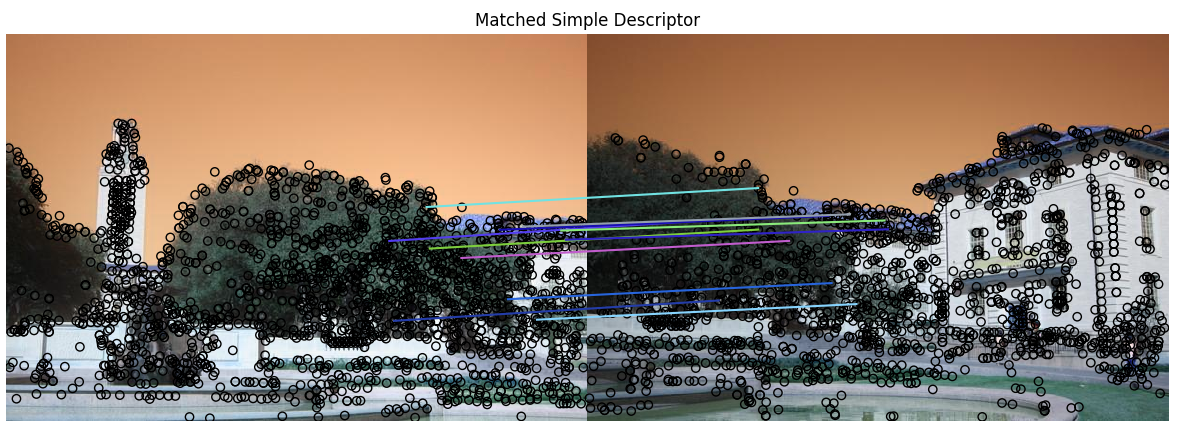

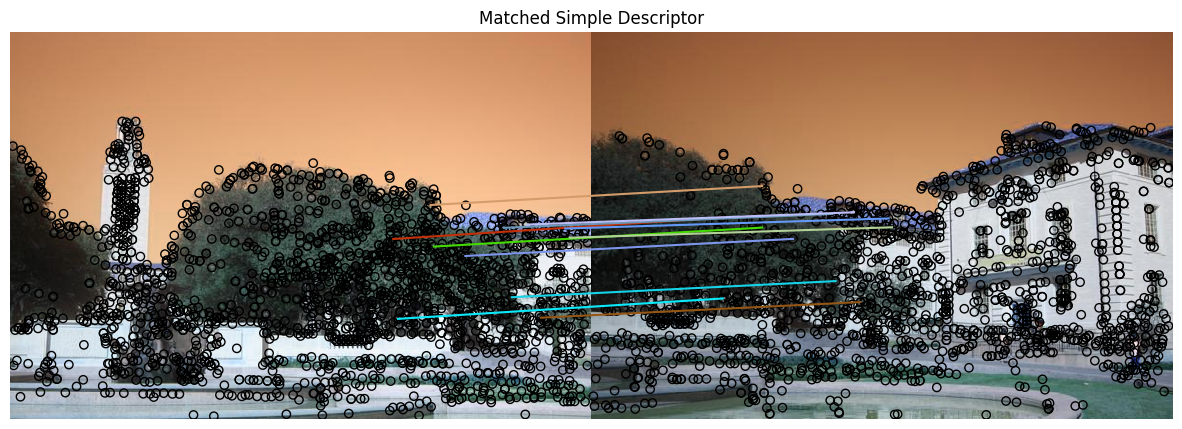

In [7]:
# TODO: implement this function
# input: des1 is a matrix of SIFT descriptors with shape [m, 128]
# input: des2 is a matrix of SIFT descriptors with shape [n, 128]
# output: index is an array with lenth q, where the ith element indicates the matched descriptor from des2 for the ith descriptor in des1
# for example, if an element in index is (10, 100), that means des1[10, :] matches to des2[100, :]
# idea: for each descriptor in des1, find its matching by computing L2 distance with all the descriptors in des2
def sift_matching(des1, des2, threshold=0.1):
    """
    Match the feature descriptors by finding distances between them. A match is formed
    when the distance to the closest vector is much smaller than the distance to the
    second-closest, that is, the ratio of the distances should be STRICTLY SMALLER
    than the threshold (NOT equal to). Return the matches as pairs of vector indices.

    Hint:
        The Numpy functions np.sort, np.argmin, np.asarray might be useful

        The Scipy function cdist calculates Euclidean distance between all
        pairs of inputs
    Args:
        des1: an array of shape (M, P) holding descriptors of size P about M keypoints
        des2: an array of shape (N, P) holding descriptors of size P about N keypoints

    Returns:
        matches: an array of shape (Q, 2) where each row holds the indices of one pair
        of matching descriptors
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    pair = []

    dis = cdist(des1, des2, 'euclidean')

    for i in range(dis.shape[0]):
        sorted_dis = np.argsort(dis[i])
        closest_dis = dis[i][sorted_dis[0]]
        c2nd_closest_dis = dis[i][sorted_dis[1]]

        if (closest_dis < c2nd_closest_dis) and ((closest_dis / c2nd_closest_dis) < threshold):
            pair.append((i, sorted_dis[0]))

    index = np.asarray(pair)
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ### END YOUR CODE
    return index

# Verify results, im1.jpg and im2.jpg should share some similar contents
im1 = cv2.imread('uttower1.jpg')
im2 = cv2.imread('uttower2.jpg')
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(im1,None)
kp2, des2 = sift.detectAndCompute(im2,None)

matches_index = sift_matching(des1, des2, threshold=0.2)

# Plot matches
# Convert keypoints to numy array, with each row is a tuple of (row_index, c_index)
kp1_arr = cv2.KeyPoint_convert(kp1)[:, ::-1]
kp2_arr = cv2.KeyPoint_convert(kp2)[:, ::-1]

fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plt.title('Matched Simple Descriptor')
plot_matches(ax, im1, im2, kp1_arr, kp2_arr, matches_index)
plt.show()